# test_dspl

Notebook 版的 `hmc_scripts/run_dspl_hmc.py`，包含 clean/noisy 两次 HMC、divergence 打印、trace plot 与 overlay corner。


In [1]:
import os
os.environ.setdefault('HDF5_USE_FILE_LOCKING', 'FALSE')

from pathlib import Path
import sys

workdir = Path.cwd()
if (workdir / 'hmc_scripts').exists() is False:
    workdir = Path('/users/tianli/LensedUniverse')
os.chdir(workdir)
if str(workdir) not in sys.path:
    sys.path.insert(0, str(workdir))


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, init_to_value
import arviz as az

from slcosmo import tool
from hmc_scripts.corner_utils import select_corner_vars, make_overlay_corner

USE_X64 = os.environ.get('SLCOSMO_USE_X64', '0').strip().lower() in {'1', 'true', 'yes', 'y', 'on'}
jax.config.update('jax_enable_x64', USE_X64)
if USE_X64:
    numpyro.enable_x64()
if any(d.platform == 'gpu' for d in jax.devices()):
    numpyro.set_platform('gpu')
else:
    numpyro.set_platform('cpu')
print('Precision mode:', 'FP64' if USE_X64 else 'FP32')

SEED = 42
rng_np = np.random.default_rng(SEED)
np.random.seed(SEED)

TEST_MODE = False
RESULT_DIR = Path('/mnt/lustre/tianli/LensedUniverse_result')
RESULT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = workdir / 'result'
FIG_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path(os.environ.get('SLCOSMO_DATA_DIR', str(workdir / 'data')))


Precision mode: FP32


In [3]:
cosmo_true = {'Omegam': 0.32, 'Omegak': 0.0, 'w0': -1.0, 'wa': 0.0, 'h0': 70.0}
cosmo_prior = {
    'w0_up': 0.0,   'w0_low': -2.0,
    'wa_up': 2.0,   'wa_low': -2.0,
    'omegak_up': 1.0, 'omegak_low': -1.0,
    'h0_up': 80.0,  'h0_low': 60.0,
    'omegam_up': 0.5, 'omegam_low': 0.1,
}
DSPL_TARGET = 500
PHOTO_FRAC_ZS2 = 0.60

print('Loading DSPL catalog...')
data_dspl = np.loadtxt(DATA_DIR / 'EuclidDSPLs_1.txt')
data_dspl = data_dspl[(data_dspl[:, 5] < 0.95)]

zl_dspl  = data_dspl[:, 0]
zs1_dspl = data_dspl[:, 1]
zs2_true_cat = data_dspl[:, 2]

beta_err_dspl = data_dspl[:, 6]
model_vel_dspl = data_dspl[:, 11]

print('Catalog zs2<=zs1 count =', int(np.sum(zs2_true_cat <= zs1_dspl)), '/', len(zs2_true_cat), '(no pre-filter)')

N_all = len(zl_dspl)
if N_all > DSPL_TARGET:
    select_idx = np.sort(rng_np.choice(N_all, size=DSPL_TARGET, replace=False))
    zl_dspl = zl_dspl[select_idx]
    zs1_dspl = zs1_dspl[select_idx]
    zs2_true_cat = zs2_true_cat[select_idx]
    beta_err_dspl = beta_err_dspl[select_idx]
    model_vel_dspl = model_vel_dspl[select_idx]
N_dspl = len(zl_dspl)
print('N_dspl used =', N_dspl)

n_photo = int(round(PHOTO_FRAC_ZS2 * N_dspl))
n_photo = max(0, min(n_photo, N_dspl))
is_photo = np.zeros(N_dspl, dtype=bool)
if n_photo > 0:
    photo_idx = rng_np.choice(N_dspl, size=n_photo, replace=False)
    is_photo[photo_idx] = True
print('source2 photo-z count =', int(is_photo.sum()), 'fraction =', float(is_photo.mean()))
zs2_err = np.where(is_photo, 0.1, 1e-4)
zs2_obs = zs2_true_cat + rng_np.normal(0.0, zs2_err)

eps = 1e-3
bad = zs2_obs <= (zs1_dspl + eps)
for _ in range(20):
    if not np.any(bad):
        break
    zs2_obs[bad] = zs2_true_cat[bad] + rng_np.normal(0.0, zs2_err[bad])
    bad = zs2_obs <= (zs1_dspl + eps)
zs2_obs = np.maximum(zs2_obs, zs1_dspl + eps)

Dl1, Ds1, Dls1 = tool.compute_distances(zl_dspl, zs1_dspl, cosmo_true)
Dl2, Ds2, Dls2 = tool.compute_distances(zl_dspl, zs2_true_cat, cosmo_true)
beta_geom_dspl = Dls1 * Ds2 / (Ds1 * Dls2)

lambda_true = tool.truncated_normal(1.0, 0.05, 0.85, 1.15, N_dspl, random_state=rng_np)
lambda_err = lambda_true * 0.1

true_vel = model_vel_dspl * jnp.sqrt(lambda_true)
vel_err = 0.03 * true_vel

beta_true = tool.beta_antimst(beta_geom_dspl, mst=lambda_true)

lambda_obs_clean = lambda_true
beta_obs_clean = beta_true
zs2_use_clean = zs2_true_cat

lambda_obs_noisy = lambda_true + rng_np.normal(0.0, lambda_err)
beta_obs_noisy = tool.truncated_normal(beta_true, beta_err_dspl, 0.0, 1.0, random_state=rng_np)
zs2_use_noisy = zs2_obs


def build_data(lambda_obs, beta_obs, zs2_use):
    spec_mask = ~is_photo
    return {
        'zl': zl_dspl,
        'zs1': zs1_dspl,
        'zs2_cat': zs2_true_cat,
        'zs2_obs': zs2_use,
        'zs2_err': zs2_err,
        'is_photo': is_photo.astype(np.int32),
        'beta_obs': beta_obs,
        'beta_err': beta_err_dspl,
        'v_model': model_vel_dspl,
        'v_obs': true_vel,
        'v_err': vel_err,
        'lambda_err': lambda_err,
        'lambda_obs': lambda_obs,
        'zl_photo': zl_dspl[is_photo],
        'zs1_photo': zs1_dspl[is_photo],
        'zs2_obs_photo': zs2_use[is_photo],
        'zs2_err_photo': zs2_err[is_photo],
        'beta_obs_photo': beta_obs[is_photo],
        'beta_err_photo': beta_err_dspl[is_photo],
        'lambda_obs_photo': lambda_obs[is_photo],
        'lambda_err_photo': lambda_err[is_photo],
        'zl_spec': zl_dspl[spec_mask],
        'zs1_spec': zs1_dspl[spec_mask],
        'zs2_obs_spec': zs2_use[spec_mask],
        'beta_obs_spec': beta_obs[spec_mask],
        'beta_err_spec': beta_err_dspl[spec_mask],
        'lambda_obs_spec': lambda_obs[spec_mask],
        'lambda_err_spec': lambda_err[spec_mask],
    }


ds_data_clean = build_data(lambda_obs_clean, beta_obs_clean, zs2_use_clean)
ds_data_noisy = build_data(lambda_obs_noisy, beta_obs_noisy, zs2_use_noisy)

print('Photo-z fraction in zs2 =', float(is_photo.mean()))


Loading DSPL catalog...
Catalog zs2<=zs1 count = 0 / 1434 (no pre-filter)
N_dspl used = 500
source2 photo-z count = 300 fraction = 0.6
Photo-z fraction in zs2 = 0.6


In [4]:
def cosmology_model(kind, cosmo_prior, sample_h0=True):
    cosmo = {
        'Omegam': numpyro.sample('Omegam', dist.Uniform(cosmo_prior['omegam_low'], cosmo_prior['omegam_up'])),
        'Omegak': 0.0,
        'w0': -1.0,
        'wa': 0.0,
        'h0': 70.0,
    }
    if kind in ['wcdm', 'owcdm', 'waw0cdm', 'owaw0cdm']:
        cosmo['w0'] = numpyro.sample('w0', dist.Uniform(cosmo_prior['w0_low'], cosmo_prior['w0_up']))
    if kind in ['waw0cdm', 'owaw0cdm']:
        cosmo['wa'] = numpyro.sample('wa', dist.Uniform(cosmo_prior['wa_low'], cosmo_prior['wa_up']))
    if kind in ['owcdm', 'owaw0cdm']:
        cosmo['Omegak'] = numpyro.sample('Omegak', dist.Uniform(cosmo_prior['omegak_low'], cosmo_prior['omegak_up']))
    if sample_h0:
        cosmo['h0'] = numpyro.sample('h0', dist.Uniform(cosmo_prior['h0_low'], cosmo_prior['h0_up']))
    return cosmo


def dspl_model(dspl_data):
    cosmo = cosmology_model('waw0cdm', cosmo_prior, sample_h0=True)

    lambda_mean = numpyro.sample('lambda_mean', dist.Uniform(0.9, 1.1))
    lambda_sigma = numpyro.sample('lambda_sigma', dist.TruncatedNormal(0.05, 0.5, low=0.0, high=0.2))

    n_photo = int(np.asarray(dspl_data['zl_photo']).shape[0])
    n_spec = int(np.asarray(dspl_data['zl_spec']).shape[0])
    eps = 1e-3

    if n_photo > 0:
        zl_photo = jnp.asarray(dspl_data['zl_photo'])
        zs1_photo = jnp.asarray(dspl_data['zs1_photo'])
        zs2_obs_photo = jnp.asarray(dspl_data['zs2_obs_photo'])
        zs2_err_photo = jnp.asarray(dspl_data['zs2_err_photo'])

        Dl1_photo, Ds1_photo, Dls1_photo = tool.compute_distances(zl_photo, zs1_photo, cosmo)
        # Sample latent source redshifts only for photo-z systems; treating near-spec-z points as latent can stall NUTS at high target_accept.
        zs2_true_photo = numpyro.sample(
            'zs2_true_photo',
            dist.TruncatedNormal(zs2_obs_photo, zs2_err_photo, low=zs1_photo + eps, high=10.0).to_event(1),
        )
        Dl2_photo, Ds2_photo, Dls2_photo = tool.compute_distances(zl_photo, zs2_true_photo, cosmo)
        beta_geom_photo = Dls1_photo * Ds2_photo / (Ds1_photo * Dls2_photo)

        with numpyro.plate('dspl_photo', n_photo):
            lambda_photo = numpyro.sample('lambda_dspl_photo', dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.5, high=1.5))
            numpyro.sample('lambda_dspl_photo_like', dist.Normal(lambda_photo, dspl_data['lambda_err_photo']), obs=dspl_data['lambda_obs_photo'])
            beta_mst_photo = tool.beta_antimst(beta_geom_photo, lambda_photo)
            numpyro.sample(
                'beta_dspl_photo_like',
                dist.TruncatedNormal(beta_mst_photo, dspl_data['beta_err_photo'], low=0.0, high=1.0),
                obs=dspl_data['beta_obs_photo'],
            )

    if n_spec > 0:
        zl_spec = jnp.asarray(dspl_data['zl_spec'])
        zs1_spec = jnp.asarray(dspl_data['zs1_spec'])
        zs2_spec = jnp.asarray(dspl_data['zs2_obs_spec'])

        Dl1_spec, Ds1_spec, Dls1_spec = tool.compute_distances(zl_spec, zs1_spec, cosmo)
        Dl2_spec, Ds2_spec, Dls2_spec = tool.compute_distances(zl_spec, zs2_spec, cosmo)
        beta_geom_spec = Dls1_spec * Ds2_spec / (Ds1_spec * Dls2_spec)

        with numpyro.plate('dspl_spec', n_spec):
            lambda_spec = numpyro.sample('lambda_dspl_spec', dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.5, high=1.5))
            numpyro.sample('lambda_dspl_spec_like', dist.Normal(lambda_spec, dspl_data['lambda_err_spec']), obs=dspl_data['lambda_obs_spec'])
            beta_mst_spec = tool.beta_antimst(beta_geom_spec, lambda_spec)
            numpyro.sample(
                'beta_dspl_spec_like',
                dist.TruncatedNormal(beta_mst_spec, dspl_data['beta_err_spec'], low=0.0, high=1.0),
                obs=dspl_data['beta_obs_spec'],
            )


def build_init_values(dspl_data):
    init_values = {
        'Omegam': jnp.asarray(cosmo_true['Omegam']),
        'w0': jnp.asarray(cosmo_true['w0']),
        'wa': jnp.asarray(cosmo_true['wa']),
        'h0': jnp.asarray(cosmo_true['h0']),
        'lambda_mean': jnp.asarray(1.0),
        'lambda_sigma': jnp.asarray(0.08),
    }
    n_photo = int(np.asarray(dspl_data['zl_photo']).shape[0])
    n_spec = int(np.asarray(dspl_data['zl_spec']).shape[0])
    if n_photo > 0:
        zs2_true_photo = np.asarray(dspl_data['zs2_obs_photo'], dtype=np.float64)
        zs1_photo = np.asarray(dspl_data['zs1_photo'], dtype=np.float64)
        zs2_true_photo = np.maximum(zs2_true_photo, zs1_photo + 1e-3)
        zs2_true_photo = np.clip(zs2_true_photo, zs1_photo + 1e-3, 9.999)
        lambda_photo = np.asarray(dspl_data['lambda_obs_photo'], dtype=np.float64)
        lambda_photo = np.clip(lambda_photo, 0.801, 1.199)
        init_values['zs2_true_photo'] = jnp.asarray(zs2_true_photo)
        init_values['lambda_dspl_photo'] = jnp.asarray(lambda_photo)
    if n_spec > 0:
        lambda_spec = np.asarray(dspl_data['lambda_obs_spec'], dtype=np.float64)
        lambda_spec = np.clip(lambda_spec, 0.801, 1.199)
        init_values['lambda_dspl_spec'] = jnp.asarray(lambda_spec)
    return init_values


sample: 100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]


[clean] divergences: 0


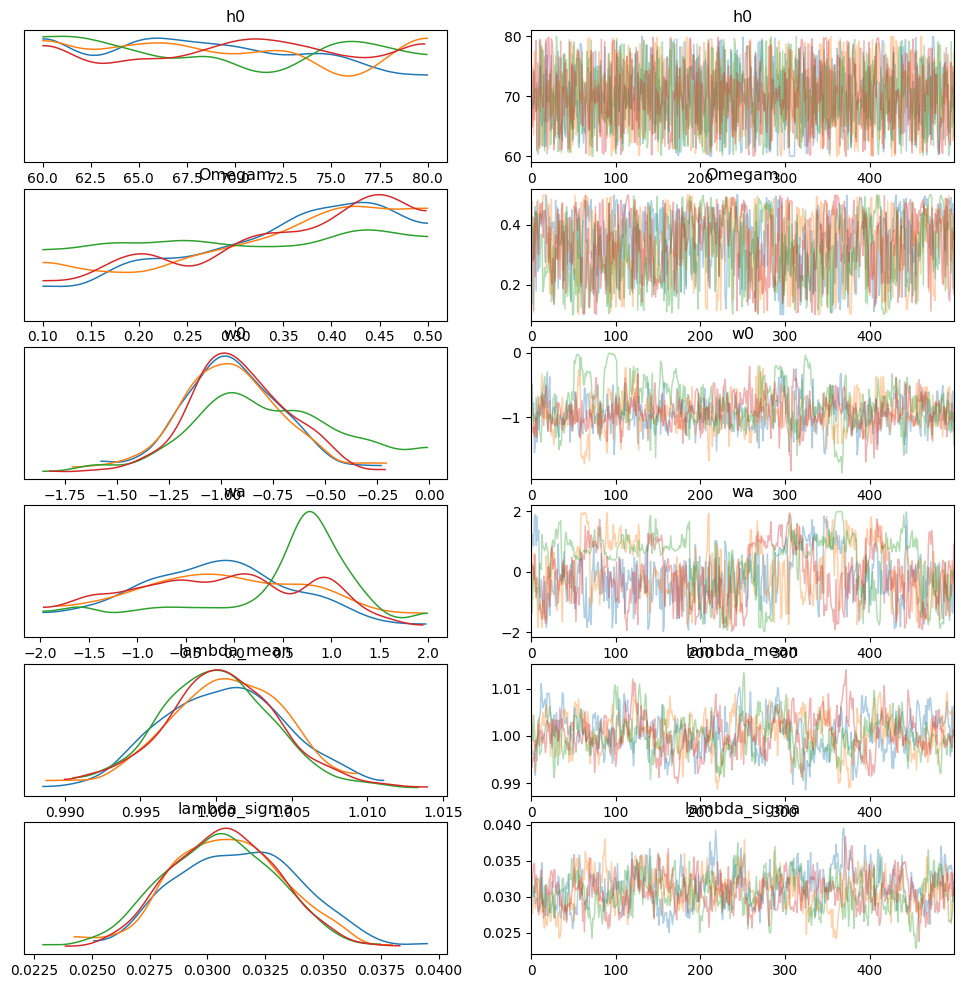

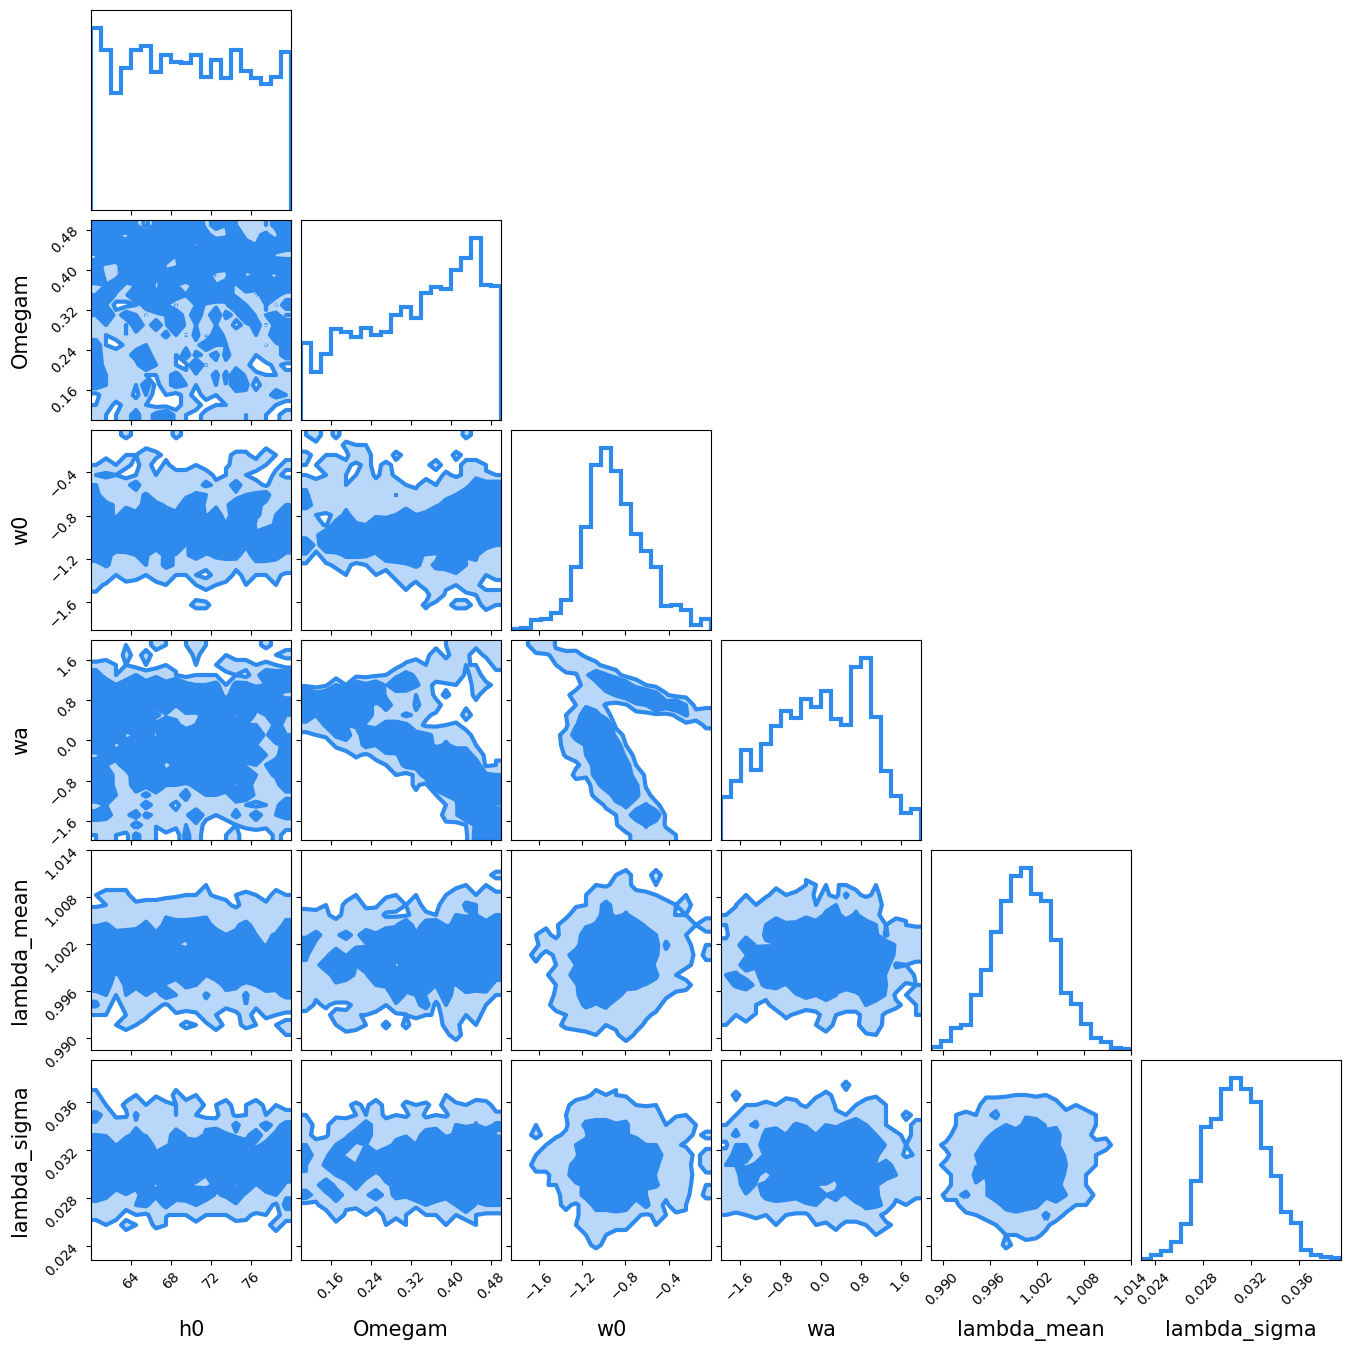

In [10]:
def run_mcmc(data, key, tag):
    if TEST_MODE:
        num_warmup, num_samples, num_chains, chain_method = 200, 200, 2, 'sequential'
    else:
        num_warmup, num_samples, num_chains, chain_method = 500, 500, 4, 'vectorized'

    nuts = NUTS(
        dspl_model,
        target_accept_prob=0.8,
        init_strategy=init_to_value(values=build_init_values(data)),
    )
    mcmc = MCMC(
        nuts,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        chain_method=chain_method,
        progress_bar=True,
    )
    mcmc.run(key, dspl_data=data)

    extra = mcmc.get_extra_fields(group_by_chain=True)
    n_div = int(np.asarray(extra['diverging']).sum())
    print(f'[{tag}] divergences: {n_div}')

    posterior = mcmc.get_samples(group_by_chain=True)
    inf_data = az.from_dict(posterior=posterior)
    az.to_netcdf(inf_data, RESULT_DIR / f'dspl_{tag}.nc')

    trace_vars = ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma']
    trace_vars = [v for v in trace_vars if v in inf_data.posterior and inf_data.posterior[v].ndim == 2]
    if trace_vars:
        trace_axes = az.plot_trace(inf_data, var_names=trace_vars, compact=False)
        trace_fig = np.asarray(trace_axes).ravel()[0].figure
        trace_fig.savefig(FIG_DIR / f'dspl_trace_{tag}.pdf', dpi=200, bbox_inches='tight')
        plt.show()
        import corner as corner
        fig = corner.corner(
        inf_data,
        var_names=trace_vars,
        labels=trace_vars,
        color="#2f8aed",
        show_titles=False,
        title_fmt=".3f",
        levels=[0.68, 0.95],
        fill_contours=True,
        plot_datapoints=False,
        smooth=0.2,
        use_math_text=True,
        label_kwargs=dict(fontsize=15),
        title_kwargs=dict(fontsize=15),
        contour_kwargs={"linewidths": 3},
        hist_kwargs={"density": True, "linewidth": 3},
        )
        plt.show()
    return inf_data


key = random.PRNGKey(42)
key_clean, key_noisy = random.split(key)

idata_clean = run_mcmc(ds_data_clean, key_clean, 'clean')
# idata_noisy = run_mcmc(ds_data_noisy, key_noisy, 'noisy')


sample: 100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]
/mnt/lustre2/shared_conda/envs/tianli/herculens_tian/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/mnt/lustre2/shared_conda/envs/tianli/herculens_tian/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


[clean] divergences: 0


/mnt/lustre2/shared_conda/envs/tianli/herculens_tian/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/mnt/lustre2/shared_conda/envs/tianli/herculens_tian/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


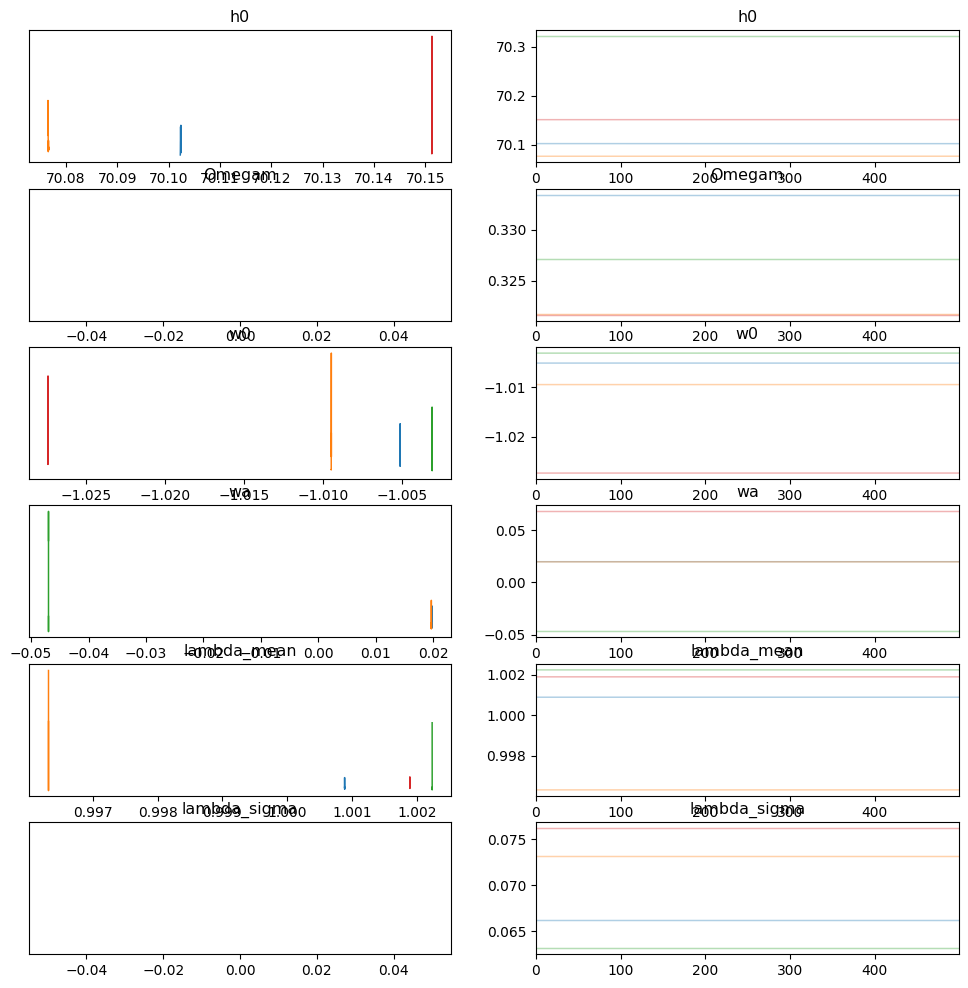

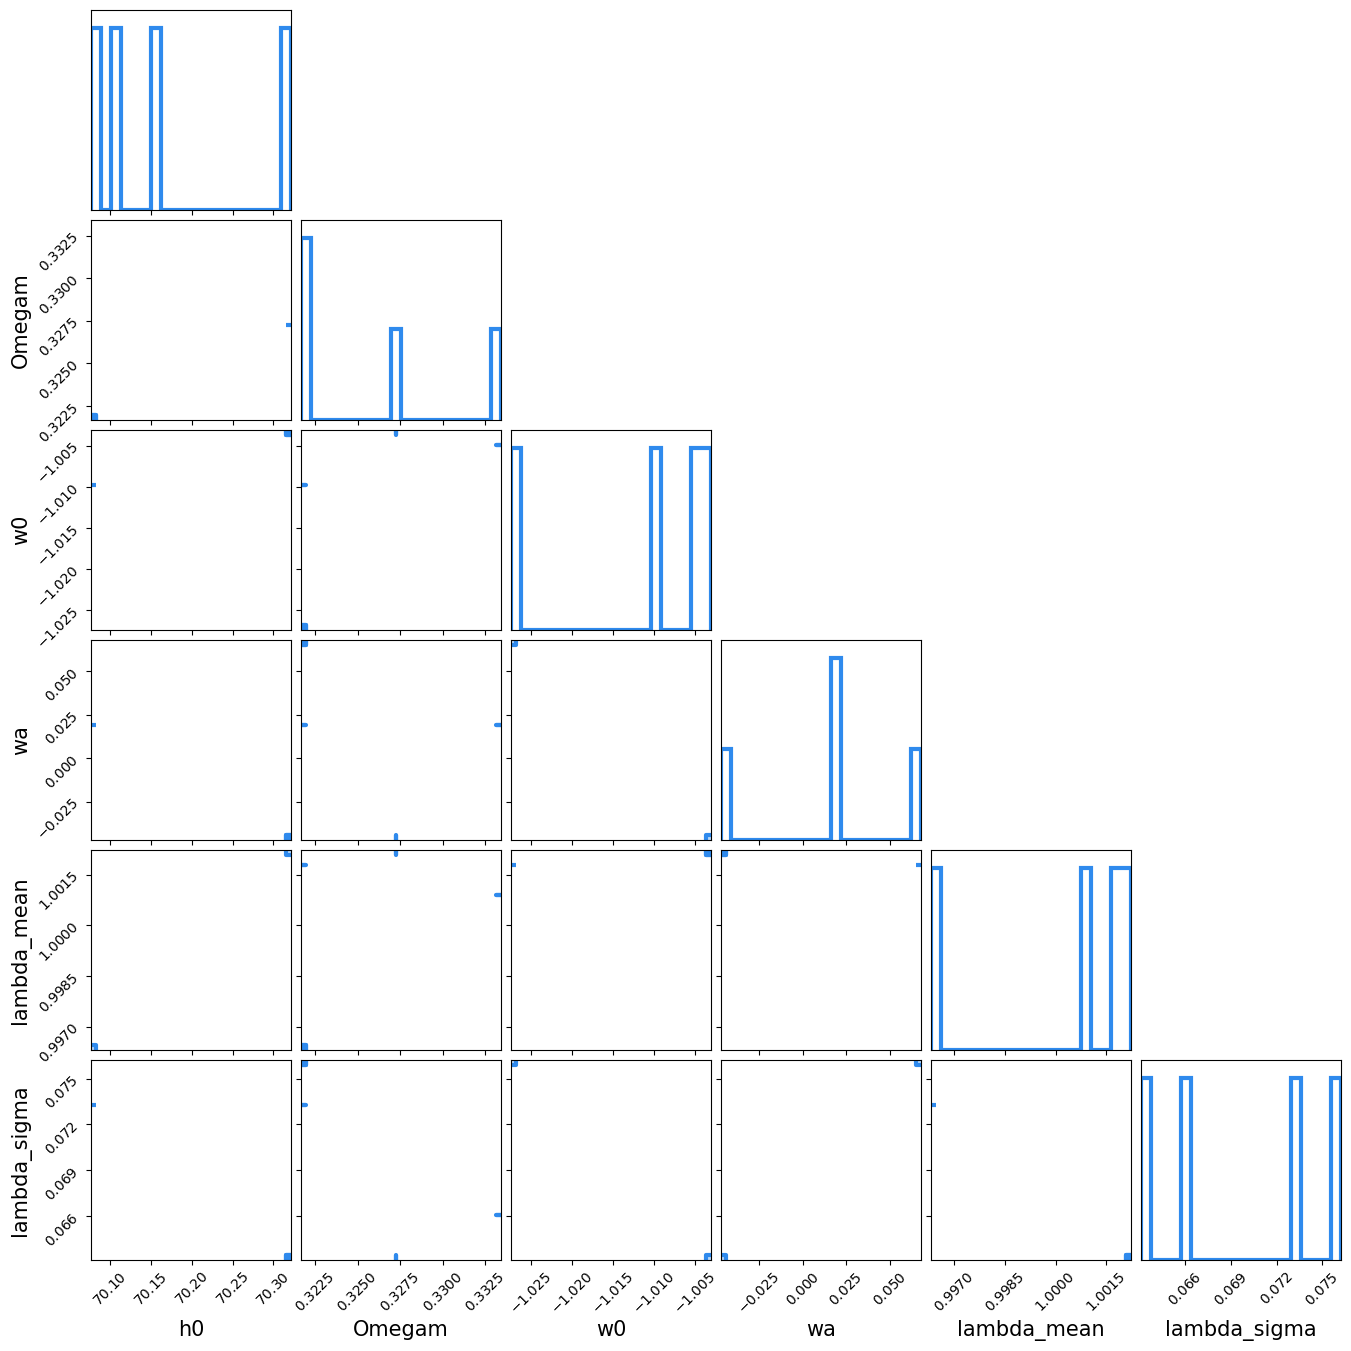

In [11]:
def run_mcmc(data, key, tag):
    if TEST_MODE:
        num_warmup, num_samples, num_chains, chain_method = 200, 200, 2, 'sequential'
    else:
        num_warmup, num_samples, num_chains, chain_method = 500, 500, 4, 'vectorized'

    nuts = NUTS(
        dspl_model,
        target_accept_prob=0.99,
        init_strategy=init_to_value(values=build_init_values(data)),
    )
    mcmc = MCMC(
        nuts,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        chain_method=chain_method,
        progress_bar=True,
    )
    mcmc.run(key, dspl_data=data)

    extra = mcmc.get_extra_fields(group_by_chain=True)
    n_div = int(np.asarray(extra['diverging']).sum())
    print(f'[{tag}] divergences: {n_div}')

    posterior = mcmc.get_samples(group_by_chain=True)
    inf_data = az.from_dict(posterior=posterior)
    az.to_netcdf(inf_data, RESULT_DIR / f'dspl_{tag}.nc')

    trace_vars = ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma']
    trace_vars = [v for v in trace_vars if v in inf_data.posterior and inf_data.posterior[v].ndim == 2]
    if trace_vars:
        trace_axes = az.plot_trace(inf_data, var_names=trace_vars, compact=False)
        trace_fig = np.asarray(trace_axes).ravel()[0].figure
        trace_fig.savefig(FIG_DIR / f'dspl_trace_{tag}.pdf', dpi=200, bbox_inches='tight')
        plt.show()
        import corner as corner
        fig = corner.corner(
        inf_data,
        var_names=trace_vars,
        labels=trace_vars,
        color="#2f8aed",
        show_titles=False,
        title_fmt=".3f",
        levels=[0.68, 0.95],
        fill_contours=True,
        plot_datapoints=False,
        smooth=0.2,
        use_math_text=True,
        label_kwargs=dict(fontsize=15),
        title_kwargs=dict(fontsize=15),
        contour_kwargs={"linewidths": 3},
        hist_kwargs={"density": True, "linewidth": 3},
        )
        plt.show()
    return inf_data


key = random.PRNGKey(42)
key_clean, key_noisy = random.split(key)

idata_clean = run_mcmc(ds_data_clean, key_clean, 'clean')
# idata_noisy = run_mcmc(ds_data_noisy, key_noisy, 'noisy')


In [ ]:
import os
os.environ.setdefault("HDF5_USE_FILE_LOCKING", "FALSE")

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC

from slcosmo import tool

# ---------- config ----------
jax.config.update("jax_enable_x64", True)
numpyro.enable_x64()
numpyro.set_platform("cpu")  # 如需GPU可改为 "gpu"

TEST_DIR = Path("test")
TEST_DIR.mkdir(parents=True, exist_ok=True)

seed = 42
zl_true, zs_true = 0.5, 1.0
sigma_zl, sigma_zs = 0.2, 0.2

# 把“观测中心”设为真值（你说的 0.5±0.2, 1.0±0.2）
zl_obs, zs_obs = zl_true, zs_true

cosmo = {"Omegam": 0.32, "Omegak": 0.0, "w0": -1.0, "wa": 0.0, "h0": 70.0}
cosmo_prior = {
    "w0_up": 0.0,   "w0_low": -2.0,
    "wa_up": 2.0,   "wa_low": -2.0,
    "omegak_up": 1.0, "omegak_low": -1.0,
    "h0_up": 80.0,  "h0_low": 60.0,
    "omegam_up": 0.5, "omegam_low": 0.1,
}

def cosmology_model(kind, cosmo_prior, sample_h0=True):
    cosmo = {
        "Omegam": numpyro.sample("Omegam", dist.Uniform(cosmo_prior["omegam_low"], cosmo_prior["omegam_up"])),
        "Omegak": 0.0,
        "w0": -1.0,
        "wa": 0.0,
        "h0": 70.0,
    }
    if kind in ["wcdm", "owcdm", "waw0cdm", "owaw0cdm"]:
        cosmo["w0"] = numpyro.sample("w0", dist.Uniform(cosmo_prior["w0_low"], cosmo_prior["w0_up"]))
    if kind in ["waw0cdm", "owaw0cdm"]:
        cosmo["wa"] = numpyro.sample("wa", dist.Uniform(cosmo_prior["wa_low"], cosmo_prior["wa_up"]))
    if kind in ["owcdm", "owaw0cdm"]:
        cosmo["Omegak"] = numpyro.sample("Omegak", dist.Uniform(cosmo_prior["omegak_low"], cosmo_prior["omegak_up"]))
    if sample_h0:
        cosmo["h0"] = numpyro.sample("h0", dist.Uniform(cosmo_prior["h0_low"], cosmo_prior["h0_up"]))
    return cosmo

def model():
    # 把“0.5±0.2, 1.0±0.2”作为观测约束
    zl = numpyro.sample("zl_like", dist.Normal(zl_obs, sigma_zl))
    zs = numpyro.sample("zs_like", dist.Normal(zs_obs, sigma_zs))
    cosmo = cosmology_model("waw0cdm", cosmo_prior, sample_h0 = False)
    zl_arr = jnp.atleast_1d(zl)
    zs_arr = jnp.atleast_1d(zs)
    _, Ds, Dls = tool.dldsdls(zl_arr, zs_arr, cosmo, n=20)
    numpyro.deterministic("Ds_over_Dls", (Ds / Dls)[0])

    numpyro.sample("dsdls", dist.Normal((Ds / Dls)[0], 0.005*ratio_true), obs = ratio_true)

# ---------- HMC ----------
nuts = NUTS(model, target_accept_prob=0.95)
mcmc = MCMC(nuts, num_warmup=500, num_samples=1000, num_chains=2, chain_method="vectorized")
mcmc.run(random.PRNGKey(seed))

posterior = mcmc.get_samples(group_by_chain=True)
idata = az.from_dict(posterior=posterior)

# divergence
extra = mcmc.get_extra_fields(group_by_chain=True)
n_div = int(np.asarray(extra["diverging"]).sum())
print(f"divergences = {n_div}")

# true value
_, Ds_true, Dls_true = tool.dldsdls(np.array([zl_true]), np.array([zs_true]), cosmo, n=20)
ratio_true = float((Ds_true / Dls_true)[0])
print("True Ds/Dls =", ratio_true)



In [ ]:
lambda_true

In [ ]:
# %%
import corner
import numpy as np
import matplotlib.pyplot as plt

# posterior 来自：posterior = mcmc.get_samples(group_by_chain=True)
w0 = np.asarray(posterior["w0"]).reshape(-1)
wa = np.asarray(posterior["wa"]).reshape(-1)
om = np.asarray(posterior["Omegam"]).reshape(-1)

samples_corner = np.vstack([w0, wa, om]).T

truths = [-1.0, 0.0, 0.32]  # w0_true, wa_true, Omegam_true
labels = [r"$w_0$", r"$w_a$", r"$\Omega_m$"]

fig = corner.corner(
    samples_corner,
    labels=labels,
    truths=truths,
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
)

plt.show()

out = TEST_DIR / "corner_w0_wa_Omegam.png"
fig.savefig(out, dpi=200, bbox_inches="tight")
print("Saved:", out)
